# 决策树模型
最高法院大法官史蒂文斯的判决
## 加载和浏览数据集
加载包

In [76]:
library(caTools)
library(rpart)
library(rpart.plot)
library(ROCR)
library(caret)
library(e1071)
library(tree)
library(randomForest)
library(class)

In [77]:
stevens = read.csv("../../datas/Stevens.csv")
str(stevens)

'data.frame':	566 obs. of  9 variables:
 $ Docket    : chr  "93-1408" "93-1577" "93-1612" "94-623" ...
 $ Term      : int  1994 1994 1994 1994 1995 1995 1996 1997 1997 1999 ...
 $ Circuit   : chr  "2nd" "9th" "5th" "1st" ...
 $ Issue     : chr  "EconomicActivity" "EconomicActivity" "EconomicActivity" "EconomicActivity" ...
 $ Petitioner: chr  "BUSINESS" "BUSINESS" "BUSINESS" "BUSINESS" ...
 $ Respondent: chr  "BUSINESS" "BUSINESS" "BUSINESS" "BUSINESS" ...
 $ LowerCourt: chr  "liberal" "liberal" "liberal" "conser" ...
 $ Unconst   : int  0 0 0 0 0 1 0 1 0 0 ...
 $ Reverse   : int  1 1 1 1 1 0 1 1 1 1 ...


我们将以下变量转换为R中的“因子”类型。我们应将变量Term转换为变量，因为我们不希望这些年来决策概率的变化采用任何递增或递减的方式。

In [78]:
stevens$Term = as.factor(stevens$Term)
stevens$Unconst = as.factor(stevens$Unconst)
stevens$Reverse = as.factor(stevens$Reverse)
stevens$Docket = as.factor(stevens$Docket)
stevens$Circuit = as.factor(stevens$Circuit)
stevens$Issue = as.factor(stevens$Issue)
stevens$Petitioner = as.factor(stevens$Petitioner)
stevens$Respondent = as.factor(stevens$Respondent)
stevens$LowerCourt = as.factor(stevens$LowerCourt)
str(stevens)

'data.frame':	566 obs. of  9 variables:
 $ Docket    : Factor w/ 566 levels "00-1011","00-1045",..: 63 69 70 145 97 181 242 289 334 436 ...
 $ Term      : Factor w/ 8 levels "1994","1995",..: 1 1 1 1 2 2 3 4 4 6 ...
 $ Circuit   : Factor w/ 13 levels "10th","11th",..: 4 11 7 3 9 11 13 11 12 2 ...
 $ Issue     : Factor w/ 11 levels "Attorneys","CivilRights",..: 5 5 5 5 9 5 5 5 5 3 ...
 $ Petitioner: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Respondent: Factor w/ 12 levels "AMERICAN.INDIAN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ LowerCourt: Factor w/ 2 levels "conser","liberal": 2 2 2 1 1 1 1 1 1 1 ...
 $ Unconst   : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 2 1 1 ...
 $ Reverse   : Factor w/ 2 levels "0","1": 2 2 2 2 2 1 2 2 2 2 ...


## 拆分数据集以进行培训和测试

我们将使用“ caTools”包中的“ sample.split”功能将数据集随机分为训练集和测试集。

In [79]:
set.seed(3000)
split = sample.split(stevens$Reverse, SplitRatio = 0.7)
train = subset(stevens, split == TRUE)
test = subset(stevens, split == FALSE)

## 建立分类和回归树（CART）模型
### 使用给定的“ minbucket”值构建CART模型
在构建我们的CART模型之前，我们需要安装和加载两个新的软件包“ rpart”和“ rpart.plot”。

现在我们准备建立模型并绘制树。现在我们仅将25用作“ minbucket”，稍后我们将使用交叉验证来优化参数的选择。

minbucket为每个子集中的点数设置一个下限（一种正则化），它越小，生成的分割就越多。

如果太小，则会发生过拟合；反之，

如果太大，模型将太简单，准确性会很差。

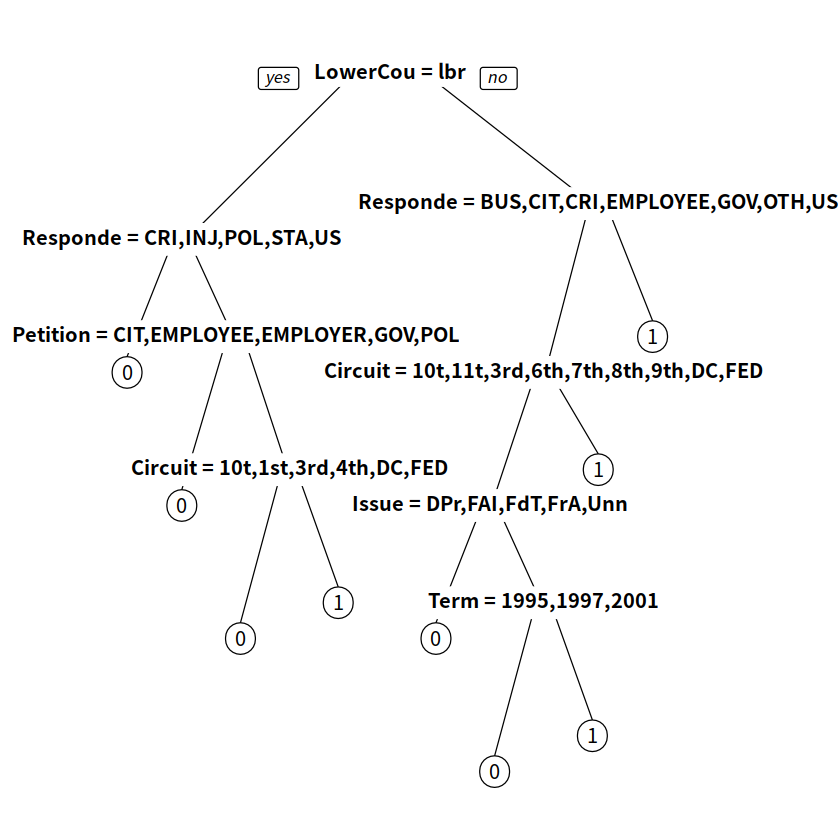

In [80]:
stevensTree = rpart(Reverse ~ Term + Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, data = train, control = rpart.control(minbucket = 25))
prp(stevensTree)

参数`method ="class"`可确保模型是分类树而不是回归树。`rpart`函数中的最后一个参数定义`minbucket`的大小以限制树，以使其不会过度拟合

`prp`函数将尽可能地缩写变量，以便仍可以唯一标识它们。为了理解`prp`函数使用的缩写，我们可以列出变量以查看每个变量的全名，以便我们可以将缩写与全名匹配。

In [81]:
table(stevens$Respondent)


    AMERICAN.INDIAN            BUSINESS                CITY  CRIMINAL.DEFENDENT 
                 13                  80                   9                  58 
           EMPLOYEE            EMPLOYER GOVERNMENT.OFFICIAL      INJURED.PERSON 
                 28                  21                  24                  14 
              OTHER          POLITICIAN               STATE                  US 
                177                  17                  56                  69 

In [82]:
table(stevens$Petitioner)


    AMERICAN.INDIAN            BUSINESS                CITY  CRIMINAL.DEFENDENT 
                  4                  79                  13                  89 
           EMPLOYEE            EMPLOYER GOVERNMENT.OFFICIAL      INJURED.PERSON 
                 30                  17                  38                   9 
              OTHER          POLITICIAN               STATE                  US 
                175                  16                  48                  48 

让我们评估CART模型的预测准确性。

In [83]:
predictCART = predict(stevensTree, newdata = test, type = "class")
conf = table(test$Reverse, predictCART)
conf

   predictCART
     0  1
  0 46 31
  1 31 62

上面的参数`type ="class"`，使用阈值`0.5`来创建混淆矩阵。默认情况下，我们通常使用`0.5`作为CART模型的阈值，因为分类主要在树结构中进行编码，并且每个叶节点都应包含相似的观察值。

我们的CART模型的准确性为63.53％，与始终预测为“反向”的基线模型的准确性55％相比要高得多。

如果您喜欢使用其他阈值，则可以要求“`预测`函数预测概率而不是类别，然后手动设置阈值以创建混淆矩阵。在以下代码中，您甚至可以删除参数`type ="prob"`，因为默认类型是概率。

In [84]:
predictCART2 = predict(stevensTree, newdata = test, type = "prob")

预测结果变量predictCART2是一个170 x 2的矩阵，如下所示。

In [85]:
dim(predictCART2)

[1] 170   2

让我们看一下predictCART2的前20行。

In [86]:
predictCART2[1:20,]

,0,1
1,0.3035714,0.6964286
3,0.3035714,0.6964286
4,0.3114754,0.6885246
6,0.5588235,0.4411765
8,0.5588235,0.4411765
21,0.3035714,0.6964286
32,0.5517241,0.4482759
36,0.5517241,0.4482759
40,0.3035714,0.6964286
42,0.5517241,0.4482759


第一列标记为0。这是与测试集观察结果相同的子集（叶节点）中结果为0的训练集数据的百分比。第二列是在与测试集观察结果相同的子集（叶节点）中具有结果1的训练集数据的百分比。我们可以将第二列解释为测试集观察结果为1的概率。请注意，每一行的索引从1到20都是不连续的。相反，它是原始数据集中随机采样之前每个数据点的索引。分为训练和测试集。换句话说，原始数据集的第一种情况，第三种情况，第四种情况等被随机选择以包括在测试集中。

现在，我们可以通过提供所需的任何阈值来生成混淆矩阵。使用0.5作为阈值将恢复参数`type ="class"`之前得到的混淆矩阵。

In [87]:
table(test$Reverse, predictCART2[,2] > 0.5)

   
    FALSE TRUE
  0    46   31
  1    31   62

我们还可以为CART模型生成ROC曲线，并计算其AUC。

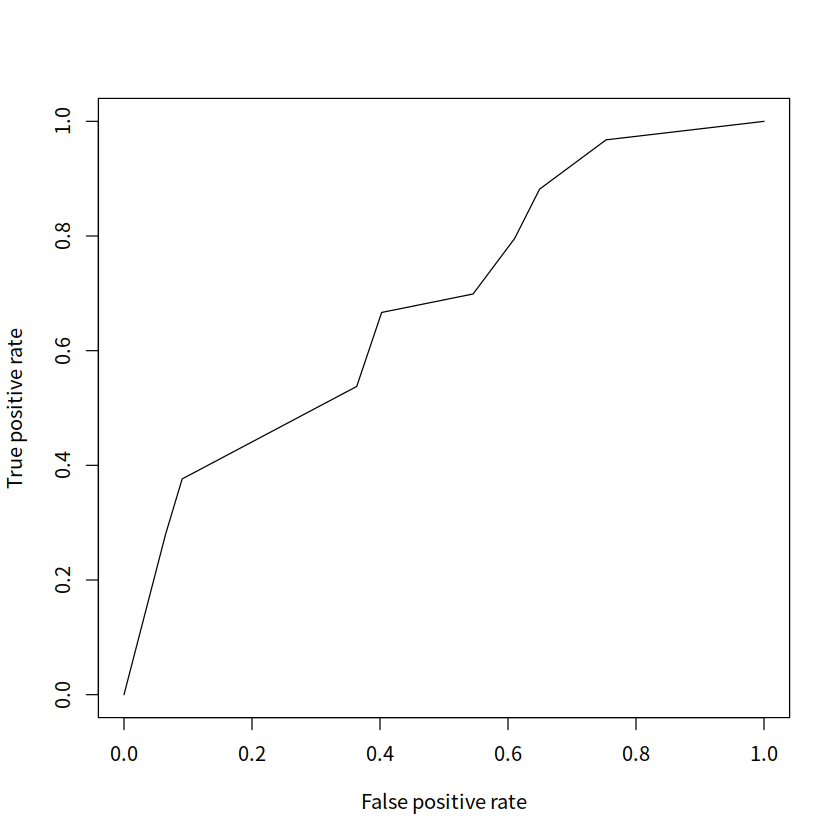

In [88]:
pred = prediction(predictCART2[,2], test$Reverse)
perf = performance(pred, "tpr", "fpr")
plot(perf)

In [89]:
auc = performance(pred, "auc")
auc@y.values[[1]]

[1] 0.6832845

## 使用交叉验证选择复杂度参数
让我们尝试对我们的CART模型进行交叉验证。为此，我们需要安装和加载两个新的软件包`caret`和`e1071`。

现在，我们将定义我们的交叉验证实验。首先，我们定义所需的折数。

In [90]:
fitControl = trainControl(method = "cv", number = 10)

第一个参数`method ="cv"`，告诉函数使用交叉验证方法。

接下来，我们需要为参数cp选择可能的值。cp通过惩罚每个拆分来控制树的增长。

cp越大（每次拆分的惩罚越高），导致树越小：`cp = 1`将导致没有拆分的树，即最小的树；相当于设置`minbucket =数据大小` ;

较小的`cp`（每次拆分的罚款较低）会导致树的增大：`cp = 0`将导致以每个数据点为叶节点的树，即最大的树；等效于设置`minbucket = 1`。

通常，我们不需要探究cp值从0到1 的整个范围。在大多数情况下，我们只需要一个小的cp值即可，例如从0.01到0.5，步长为0.01。

In [91]:
cpGrid = expand.grid(.cp = (1:50)*0.01)

现在，我们准备执行交叉验证。由于其中有一些随机成分ķ折交叉验证-随机划分为 ķ 折叠-让我们通过先设置一个公共随机种子来同步结果。

In [92]:
set.seed(33)
cvResults = train(Reverse ~ Term + Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, data = train, method = "rpart", trControl = fitControl, tuneGrid = cpGrid)
cvResults

CART 

396 samples
  7 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 356, 357, 357, 356, 356, 356, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa     
  0.01  0.6267308  0.23433745
  0.02  0.6139744  0.20969640
  0.03  0.6191026  0.22426640
  0.04  0.6291667  0.25184688
  0.05  0.6443590  0.28571708
  0.06  0.6443590  0.28571708
  0.07  0.6443590  0.28571708
  0.08  0.6443590  0.28571708
  0.09  0.6443590  0.28571708
  0.10  0.6443590  0.28571708
  0.11  0.6443590  0.28571708
  0.12  0.6443590  0.28571708
  0.13  0.6443590  0.28571708
  0.14  0.6443590  0.28571708
  0.15  0.6443590  0.28571708
  0.16  0.6443590  0.28571708
  0.17  0.6443590  0.28571708
  0.18  0.6187179  0.22698692
  0.19  0.6187179  0.22698692
  0.20  0.6187179  0.22698692
  0.21  0.5733333  0.11309826
  0.22  0.5530769  0.05337925
  0.23  0.5403846  0.01187658
  0.24  0.5403846  0.01187658
  0.25  0.5453846  0.00000000


上面输出的最下面告诉我们我们要用来构建`CART`模型的最佳cp值，接下来将要构建新的CART模型。请注意，由于我们已经将结果变量Reverse转换为因子变量，因此现在可以删除参数`method ="class"`。在以下代码中，命令`cvResults["bestTune"]`从上述交叉验证结果中获取最佳cp值。我们也可以只输入0.17。

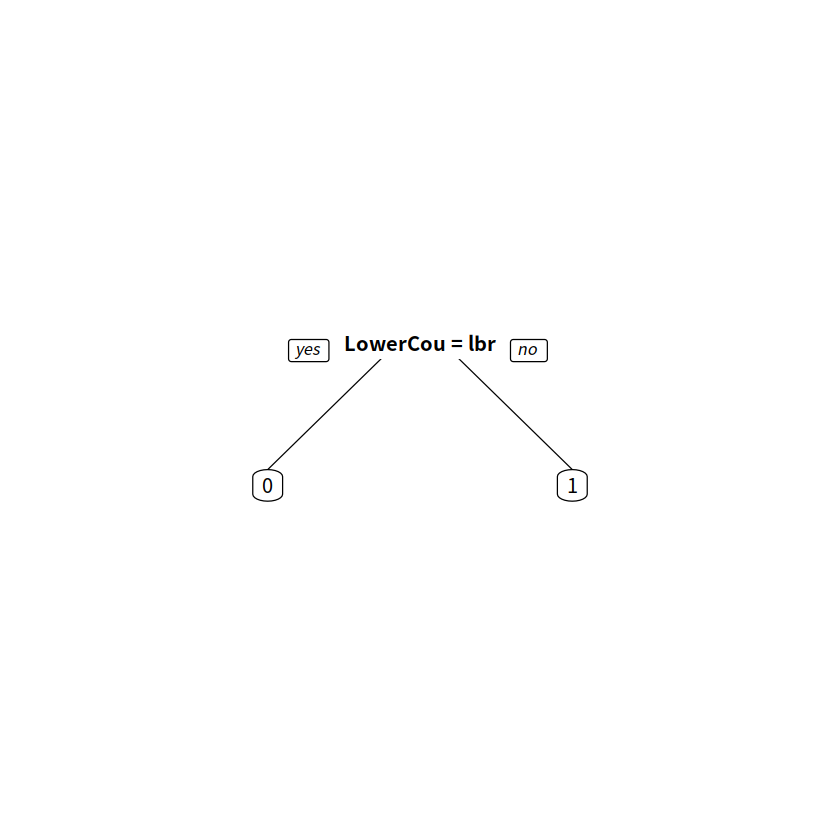

In [93]:
stevensTreeCV = rpart(Reverse ~ Term + Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, data = train, control = rpart.control(cp = cvResults["bestTune"]))
prp(stevensTreeCV)

有趣的是，使用cp参数从交叉验证过程中选择的最佳树仅在下级法院判决的意识形态方向上有一个分支。当下级法院的裁决被认为是自由的时，史蒂文斯法官就更有可能确认该裁决。但是，当下级法院的裁决被认为是保守的时，史蒂文斯大法官更有可能推翻该裁决。如下所示，此简单树的准确性超过70％。这提供了有力的证据，证明史蒂文斯大法官比保守派更自由，而不是他自己声称的。

In [94]:
predictCV = predict(stevensTreeCV, newdata = test, type = "class")
confCV = table(test$Reverse, predictCV)
confCV

   predictCV
     0  1
  0 59 18
  1 29 64

新`CART`模型的准确性为72.35％，比我们之前的CART模型的准确性为63.53％高。我们将看到，与接下来将要做的随机森林模型相比，它甚至更高。
### 与R中另一个程序包的交叉验证

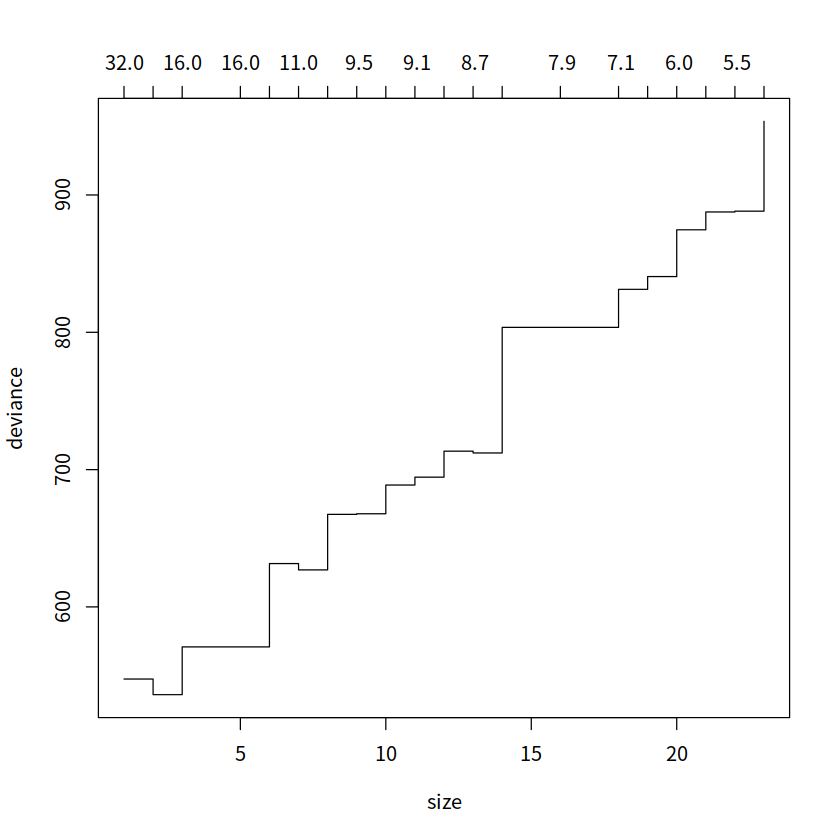

In [96]:
set.seed(30)
treeRev = tree(Reverse ~ Term + Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, data = train)
cvResult = cv.tree(treeRev,,prune.tree, K = 10)
plot(cvResult)

In [99]:
cvResult

$size
 [1] 23 22 21 20 19 18 16 14 13 12 11 10  9  8  7  6  5  3  2  1

$dev
 [1] 953.6358 888.2305 887.6445 874.6479 840.5691 831.2859 803.5763 803.5763
 [9] 712.1258 713.4176 694.4959 688.7589 667.8413 667.4122 626.9538 631.5714
[17] 570.8960 570.8960 536.0984 547.4825

$k
 [1]      -Inf  5.487169  5.939778  5.999377  6.645951  7.063352  7.927246
 [8]  7.934142  8.659141  8.788767  9.097557  9.252559  9.513109  9.573004
[15] 10.628985 10.941779 15.925130 15.976991 23.591745 32.256967

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

In [100]:
treeRevCV = prune.tree(treeRev, k = cvResult$k[which.min(cvResult$dev)])
summary(treeRevCV)


Classification tree:
snip.tree(tree = treeRev, nodes = 3:2)
Variables actually used in tree construction:
[1] "LowerCourt"
Number of terminal nodes:  2 
Residual mean deviance:  1.303 = 513.4 / 394 
Misclassification error rate: 0.3561 = 141 / 396 

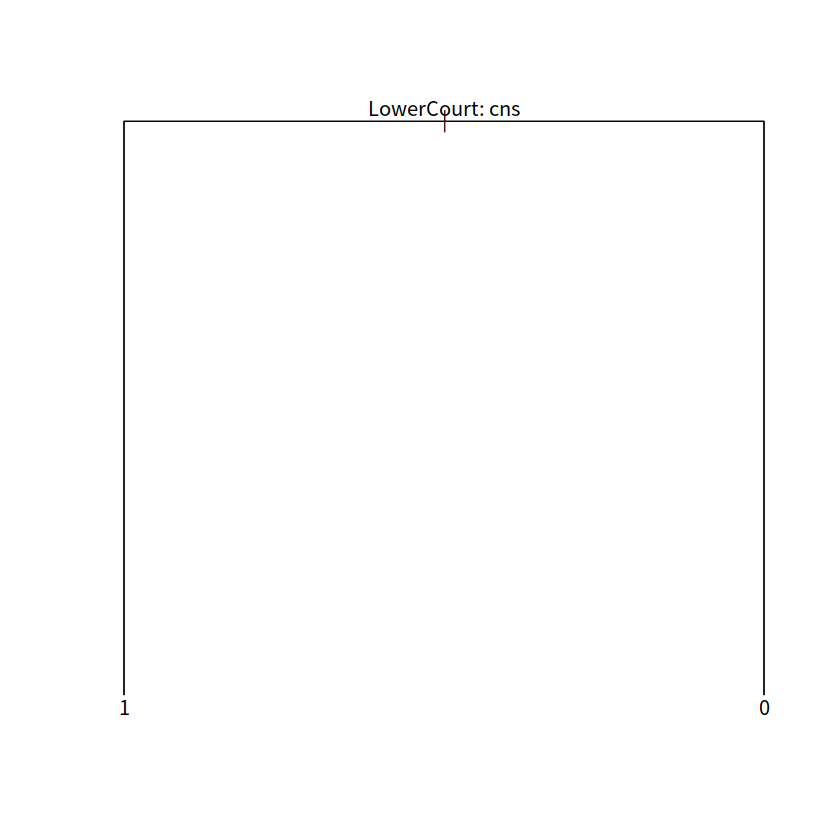

In [101]:
plot(treeRevCV)
text(treeRevCV, pretty = 3)

## 建立随机森林模型

In [97]:
set.seed(333)
stevensForest = randomForest(Reverse ~ Term + Circuit + Issue + Petitioner + Respondent + LowerCourt + Unconst, data = train, ntree = 500, nodesize = 25, mtry = 3)

In [98]:
predictForest = predict(stevensForest, newdata = test)
confRF = table(test$Reverse, predictForest)
confRF

   predictForest
     0  1
  0 45 32
  1 20 73

我们的随机森林模型的准确性为69.41％，与通过交叉验证得出的CART模型的准确性相近。可以使用交叉验证进一步微调模型，以选择最佳参数值。